In [1]:
# Insert code here.
import pandas as pd
import numpy as np
import random
import re
import time
import datetime
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, neighbors
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoModelForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
import seaborn as sns
# from sentence_transformers import SentenceTransformer
# sent_encoder = SentenceTransformer('bert-base-nli-mean-tokens')

In [2]:
models = ['bert-base-uncased', 'distilbert-base-uncased-finetuned-sst-2-english', 'textattack/roberta-base-SST-2', 'monologg/electra-small-finetuned-imdb', 'xlnet-base-cased', 'xlm-roberta-large']
model_num = 2
tokenizer = AutoTokenizer.from_pretrained(models[model_num])


In [3]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
torch.cuda.empty_cache()

There are 4 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [4]:
torch.cuda.empty_cache()
!nvidia-smi

Fri Oct 30 04:51:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.95.01    Driver Version: 440.95.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:02:00.0 Off |                  N/A |
| 41%   55C    P8    16W / 250W |     11MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:03:00.0 Off |                  N/A |
| 31%   28C    P8    20W / 250W |  10646MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [5]:
DATASET_PATH = '../datasets/nela-gt/nela10.csv'

In [6]:
df = pd.read_csv(DATASET_PATH)
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 57,157



,id,date,source,title,content,author,url,published,published_utc,collection_utc,Reliability
18969,skynewspolitics--2019-01-23--Polish-born MP ac...,2019-01-23,skynewspolitics,Polish-born MP accused of 'reckless' attempt t...,Daniel Kawczynski said he was trying to stop R...,NaN,http://news.sky.com/story/polish-born-mp-accus...,2019-01-23 14:54:00+00:00,1548273240,1567551184,0
1620,bbc--2019-07-06--Italy migrants New charity sh...,2019-07-06,bbc,Italy migrants: New charity ship docks despite...,A charity boat carrying 41 rescued migrants de...,NaN,https://www.bbc.co.uk/news/world-europe-48896038,2019-07-06 22:12:39+00:00,1562465559,1567536648,0
47698,dcgazette--2019-03-19--The Sting of Meritocracy,2019-03-19,dcgazette,The Sting of Meritocracy,I don’t think this scandal is really about how...,505335761211,https://dcgazette.com/2019/the-sting-of-merito...,2019-03-19 05:03:15+00:00,1552986195,1567545708,2
20446,spiegel--2019-01-17--Harald Schmidts Videokolu...,2019-01-17,spiegel,Harald Schmidts Videokolumne: Chouchou liebt e...,Sie haben keinen Zugang? Jetzt gratis testen!\n\n,NaN,http://www.spiegel.de/plus/harald-schmidt-uebe...,2019-01-17 15:04:04+00:00,1547755444,1567552123,0
12663,jerusalempost--2019-10-14--Spain finds Catalan...,2019-10-14,jerusalempost,Spain finds Catalan leaders guilty of sedition...,Spain's Supreme Court on Monday sentenced nine...,By REUTERS,https://www.jpost.com/Breaking-News/Spain-find...,"Mon, 14 Oct 2019 08:14:00 GMT",1571055240,1571062755,0
43244,"usnews--2019-10-14--Pinedale Man Arrested, Acc...",2019-10-14,usnews,"Pinedale Man Arrested, Accused of Fatally Shoo...","PINEDALE, Ariz. (AP) — Navajo County Sheriff's...",Associated Press,https://www.usnews.com/news/best-states/arizon...,"Mon, 14 Oct 2019 23:50:05 GMT",1571111405,1571098217,0
9945,eveningstandard--2019-09-10--Super Troupers Th...,2019-09-10,eveningstandard,Super Troupers The Exhibition: Major immersive...,"Knowing me knowing you, ABBA fans will be exci...",Zoe Paskett,https://www.standard.co.uk/go/london/arts/abba...,2019-09-10 09:45:00+00:00,1568123100,1569330536,0
2791,bbc--2019-09-30--Boris Johnson touching row co...,2019-09-30,bbc,Boris Johnson 'touching' row continues at Tory...,Boris Johnson has insisted allegations about h...,NaN,https://www.bbc.co.uk/news/uk-politics-49877508,2019-09-30 16:50:57+00:00,1569876657,1570221907,0
4567,cbsnews--2019-01-17--Facebook shuts hundreds o...,2019-01-17,cbsnews,Facebook shuts hundreds of pages linked to Rus...,Facebook says it has removed hundreds of Russi...,NaN,http://www.cbsnews.com/news/facebook-shuts-hun...,2019-01-17 14:23:21+00:00,1547753001,1567552027,0
49609,naturalnews--2019-09-16--Liberals sign petitio...,2019-09-16,naturalnews,Liberals sign petition to protect unborn eagle...,(Natural News) In the wonderful world of Los A...,Lance D Johnson,http://www.naturalnews.com/2019-09-16-liberals...,2019-09-16 21:22:31+00:00,1568683351,1569330210,2


In [7]:
def count_words(text):
    try:
        return len(text.split())
    except:
        print(text)
        return None

In [8]:
def change_rel(num):
    if num == 2:
        return 1
    else:
        return 0

In [9]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = []

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text)
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['content'] = df['content'].apply(clean_text)
df['content'] = df['content'].str.replace('\d+', '')
df['Reliability'] = df['Reliability'].apply(change_rel)

In [10]:
def get_split(text1):
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return l_total
df['content_split'] = df['content'].apply(get_split)

In [11]:
df['content'].apply(count_words).max()

15183

In [12]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['content_split'], df['Reliability'], test_size=0.2, stratify=df['Reliability'])

In [13]:
train_l = []
label_l = []
index_l =[]
for row,label in zip(train_x, train_y):
    for l in row:
        train_l.append(l)
        label_l.append(label)
len(train_l), len(label_l)

(139055, 139055)

In [14]:
val_l = []
val_label_l = []
val_index_l = []
for row,label in zip(valid_x, valid_y):
    for l in row:
        val_l.append(l)
        val_label_l.append(label)
len(val_l), len(val_label_l)

(35029, 35029)

In [15]:
MAX_LENGTH = 220
posts = train_l
categories = label_l

In [16]:
encoded_dict = tokenizer.encode_plus(
                        posts[0],                      # Sentence to encode.
                        truncation=True,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
encoded_dict

/home/tathagata.raha/miniconda3/envs/fastai/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1764: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': tensor([[    0, 30191,    81, 24134,  6907,  1207, 23491,    16,     5,  2904,
            13,   309,     7,     5, 38187,   260,  7705, 25776,   138, 16259,
          1264,  1060, 34586, 30390,  3514, 24700,    32,     5,  5135,   477,
            13, 10374,  3612,   102, 20902, 13686,  6152,   227,  8978,     8,
         34022,  1207, 23491,    16,   161, 16259,  1264, 17380, 13315, 27206,
             8,   301,  3707, 20277,     8,    40,  3495,    62,    11,  2734,
          4002,  1808,     8,  3222, 10327,  1328,     5,    76,  9178,  6294,
            24,    16,    45,    10,  5548,    19,  1521, 30016, 14847, 14926,
         28459,  1021,   571,  3194, 14897,   179,  2410,    15,     5,   263,
          2158,   225,   998,    42, 13686,    16,  1622,   350, 22636, 24262,
           833,  4520,     8, 23318,     7,    28, 18684, 19448,    79, 10648,
         16063, 17654,   959,  6138,    24,   600,     5,  4570,  5976,  2734,
          7716,     8,  7855,  1195,  

In [17]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in posts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    try:
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            truncation=True,
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )
    except:
        print(sent)
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(categories)

In [18]:
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.875 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


121,673 training samples
17,382 validation samples


In [19]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [20]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
import torch.nn as nn
model = AutoModelForSequenceClassification.from_pretrained(
    models[model_num], # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
# model = nn.DataParallel(model)
model.to(device)


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [21]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 203 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           (

In [22]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [23]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [24]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [25]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



In [36]:
seed_val = 42
torch.cuda.empty_cache()
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
#         print(loss)
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    if epoch_i >= 0:
        inp = input()
        if inp.startswith('y'):
            break

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of  3,803.    Elapsed: 0:00:17.
  Batch    80  of  3,803.    Elapsed: 0:00:35.
  Batch   120  of  3,803.    Elapsed: 0:00:52.
  Batch   160  of  3,803.    Elapsed: 0:01:10.
  Batch   200  of  3,803.    Elapsed: 0:01:27.
  Batch   240  of  3,803.    Elapsed: 0:01:45.
  Batch   280  of  3,803.    Elapsed: 0:02:03.
  Batch   320  of  3,803.    Elapsed: 0:02:21.
  Batch   360  of  3,803.    Elapsed: 0:02:39.
  Batch   400  of  3,803.    Elapsed: 0:02:57.
  Batch   440  of  3,803.    Elapsed: 0:03:15.
  Batch   480  of  3,803.    Elapsed: 0:03:33.
  Batch   520  of  3,803.    Elapsed: 0:03:51.
  Batch   560  of  3,803.    Elapsed: 0:04:09.
  Batch   600  of  3,803.    Elapsed: 0:04:27.
  Batch   640  of  3,803.    Elapsed: 0:04:45.
  Batch   680  of  3,803.    Elapsed: 0:05:03.
  Batch   720  of  3,803.    Elapsed: 0:05:21.
  Batch   760  of  3,803.    Elapsed: 0:05:39.
  Batch   800  of  3,803.    Elapsed: 0:05:57.
  Batch   840  of

 y



Training complete!
Total training took 0:35:32 (h:mm:ss)


In [37]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.""
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.15,0.27,0.92,0:28:34,0:01:22


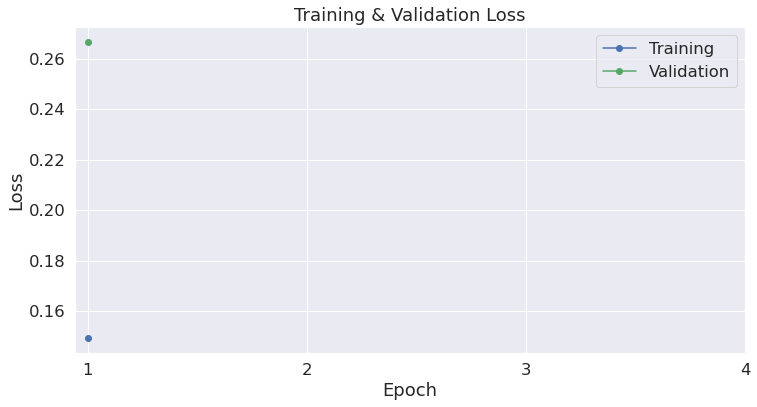

In [38]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [39]:
posts = val_l
categories = val_label_l

In [40]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in posts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        truncation=True,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(categories)

# Set the batch size.  
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


/home/tathagata.raha/miniconda3/envs/fastai/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1764: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [41]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')


Predicting labels for 35,029 test sentences...
    DONE.


In [42]:
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [43]:
from sklearn.metrics import classification_report
print(classification_report(flat_true_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94     27156
           1       0.82      0.73      0.77      7873

    accuracy                           0.90     35029
   macro avg       0.87      0.84      0.85     35029
weighted avg       0.90      0.90      0.90     35029



In [35]:
# torch.save(model, '/scratch/tathagataraha/nela-gt-article-cascadingRoberta-epoch'+str(epoch_i)+'.pt')

In [44]:
# torch.save(model, '/scratch/tathagataraha/nela-gt-article-cascadingRoberta-epoch3'.pt')

SyntaxError: EOL while scanning string literal (<ipython-input-44-6ae295bbf1d6>, line 1)